# Ungraded Lab: Implement a Siamese network

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/TensorFlow-Advanced_Techniques_Specialization/blob/master/Custom_Models_Layers_and_Loss_Functions_with_TensorFlow/Week1/Labs/C1_W1_Lab_3_siamese-network.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

This lab will go through creating and training a multi-input model. You will build a basic Siamese Network to find the similarity or dissimilarity between items of clothing. For Week 1, you will just focus on constructing the network. You will revisit this lab in Week 2 when we talk about custom loss functions.

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from keras import datasets, Input, layers, Model, config, utils, optimizers

2024-08-21 19:38:07.907595: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 19:38:07.920196: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 19:38:07.923809: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-21 19:38:07.932455: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Prepare the Dataset

First define a few utilities for preparing and visualizing your dataset.

In [2]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''

    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)

def create_pairs_on_set(images, labels):
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y

def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.axis("off")
    plt.show()

You can now download and prepare our train and test sets. You will also create pairs of images that will go into the multi-input model.

In [3]:
# Load the dataset
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

# Prepare train and test sets
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# Normalize values
train_images = train_images / 255.0
test_images = test_images / 255.0

# Create pairs on train and test sets
tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

You can see a sample pair of images below.

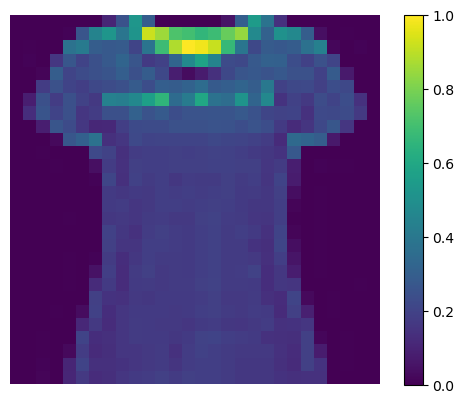

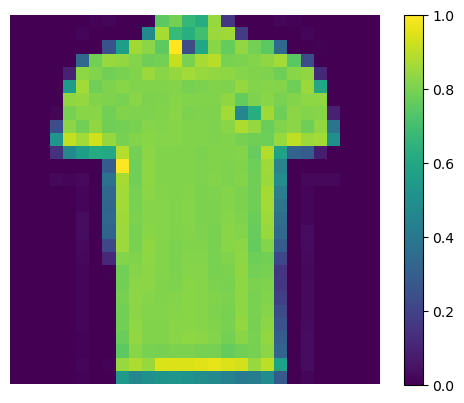

Label = 1.0


In [4]:
# Array index
this_pair = 8

# Show images at this index
show_image(ts_pairs[this_pair][0])
show_image(ts_pairs[this_pair][1])

# Print the label for this pair
print("Label =", ts_y[this_pair])

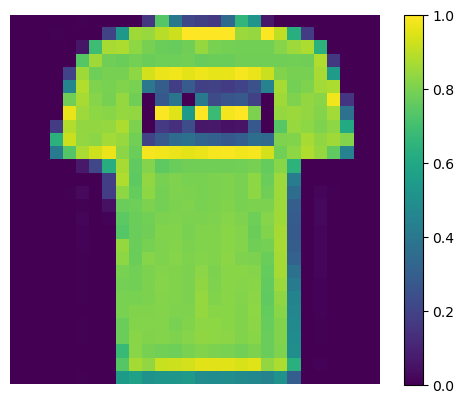

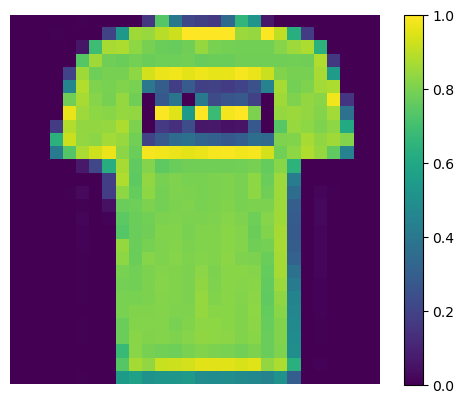

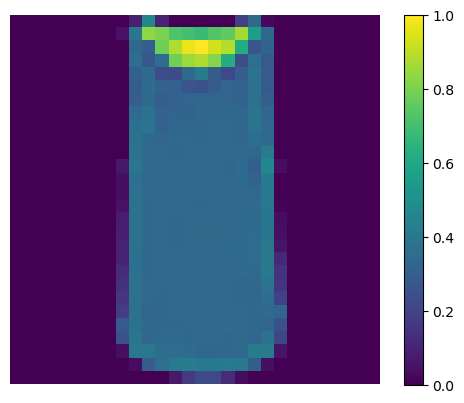

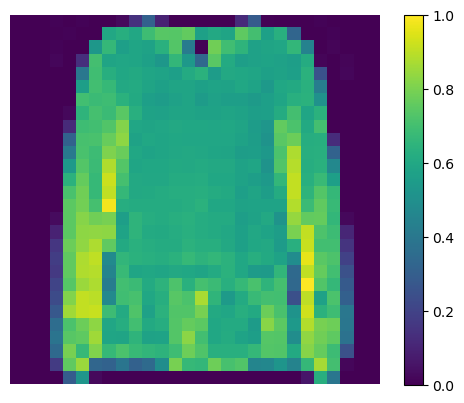

In [5]:
# Print other pairs
show_image(tr_pairs[:, 0][0])
show_image(tr_pairs[:, 0][1])

show_image(tr_pairs[:, 1][0])
show_image(tr_pairs[:, 1][1])

## Build the Model

Next, you'll define some utilities for building our model.

In [6]:
def initialize_base_network():
    input = Input(shape=(28, 28,), name="base_input")
    x = layers.Flatten(name="flatten_input")(input)
    x = layers.Dense(128, activation='relu', name="first_base_dense")(x)
    x = layers.Dropout(0.1, name="first_dropout")(x)
    x = layers.Dense(128, activation='relu', name="second_base_dense")(x)
    x = layers.Dropout(0.1, name="second_dropout")(x)
    x = layers.Dense(128, activation='relu', name="third_base_dense")(x)

    return Model(inputs=input, outputs=x)

def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)

    return tf.sqrt(tf.maximum(sum_square, config.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    
    return (shape1[0], 1)

Let's see how our base network looks. This is where the two inputs will pass through to generate an output vector.

2024-08-21 19:38:11.458932: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1823 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


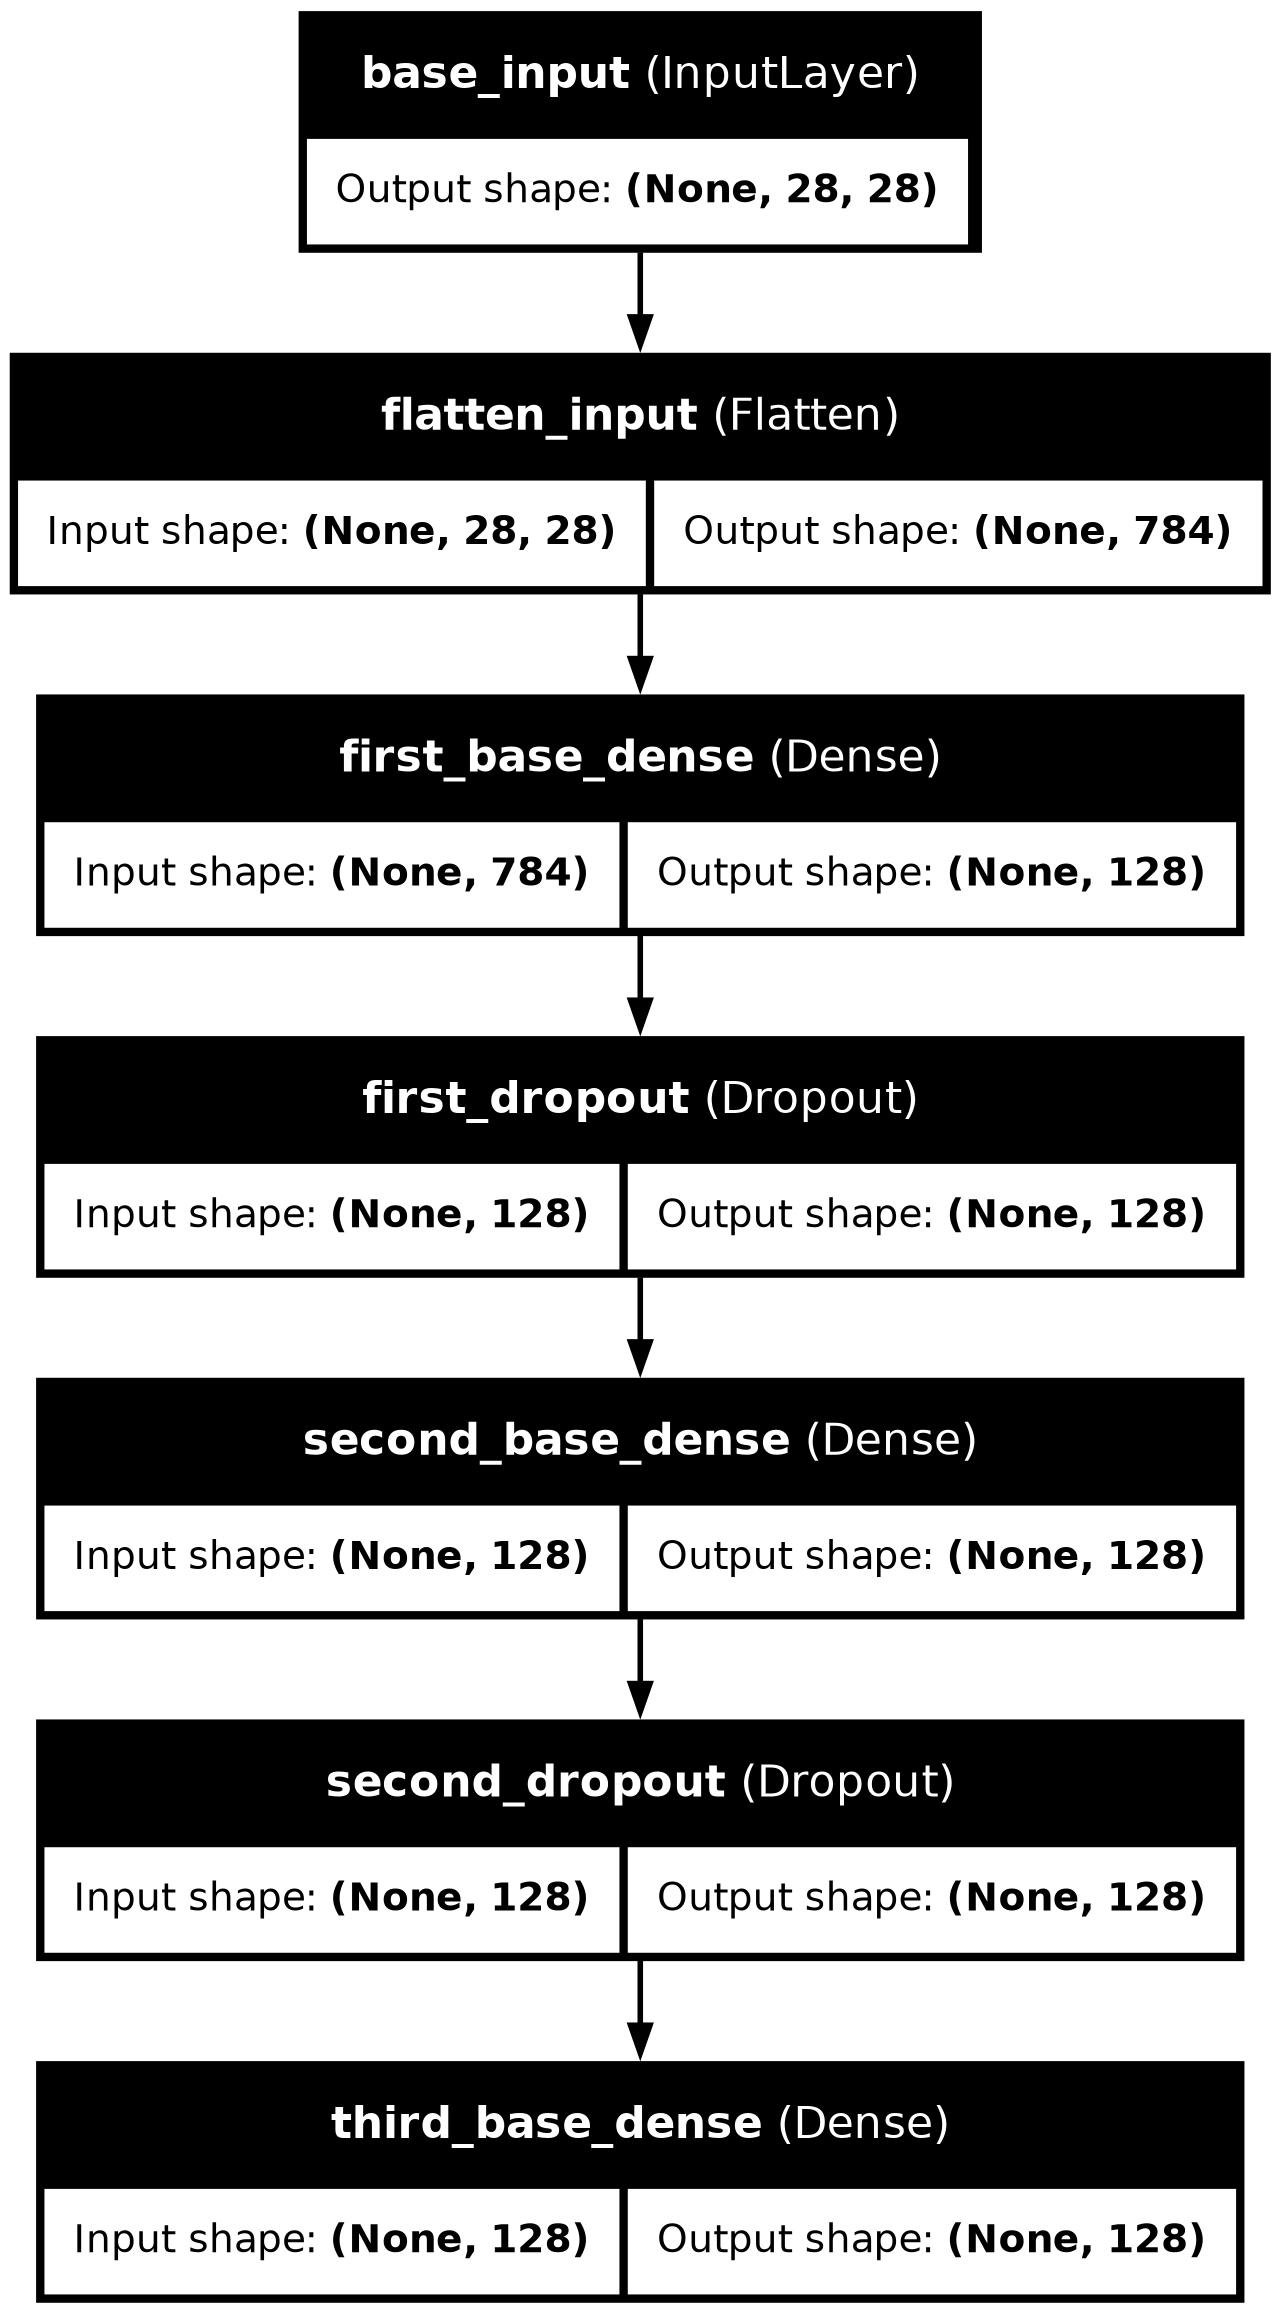

In [7]:
base_network = initialize_base_network()
utils.plot_model(base_network, show_shapes=True, show_layer_names=True, to_file='./base-model.png')

Let's now build the Siamese network. The plot will show two inputs going to the base network.

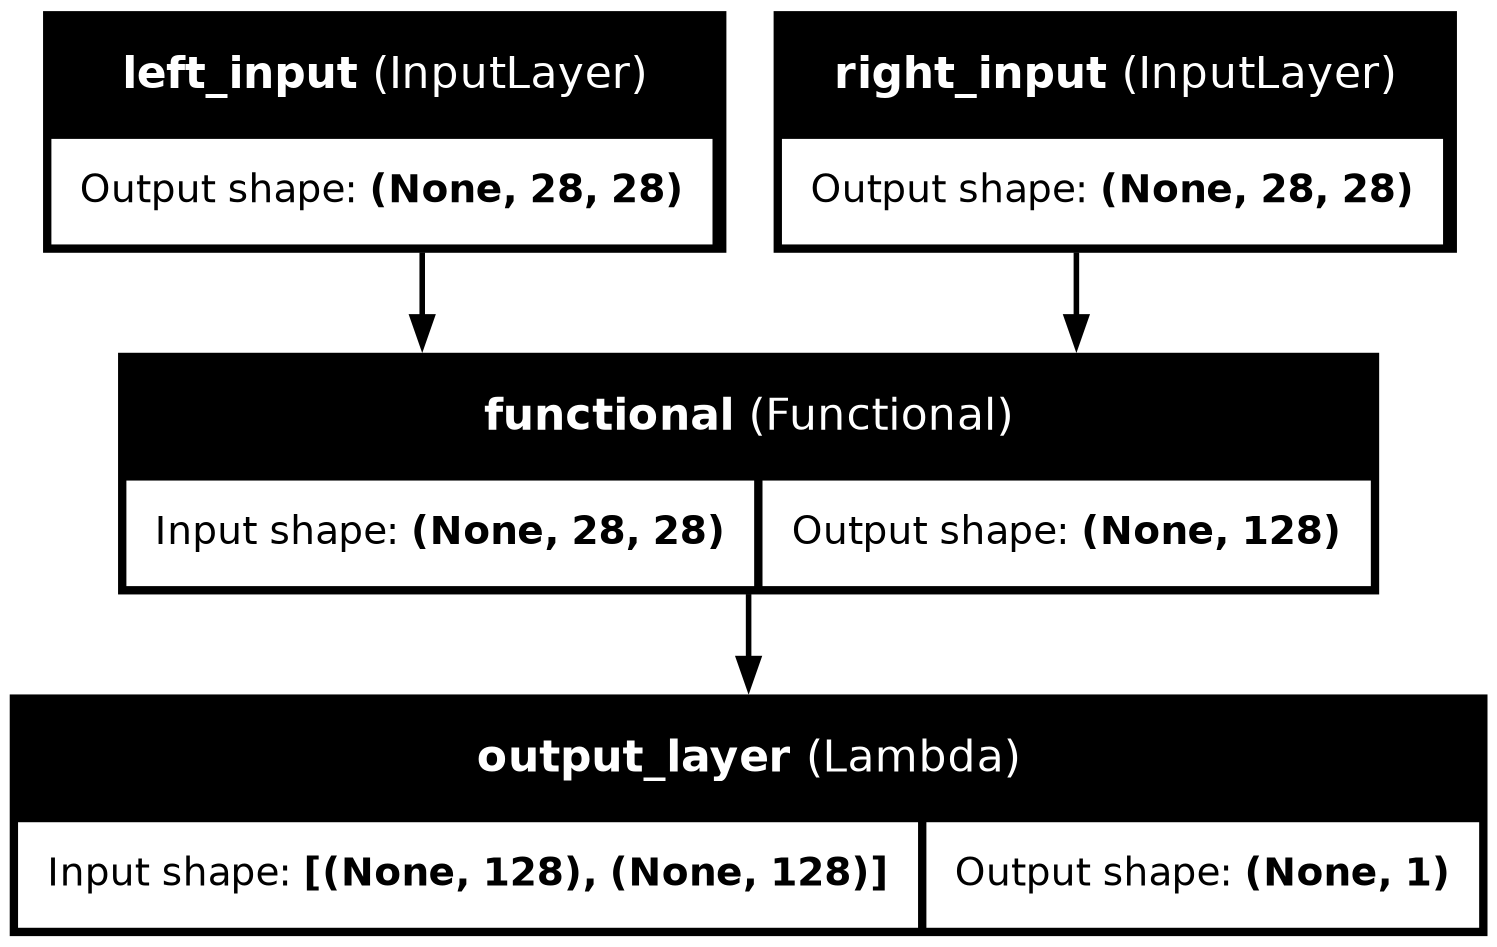

In [8]:
# create the left input and point to the base network
input_a = Input(shape=(28, 28,), name="left_input")
vect_output_a = base_network(input_a)

# create the right input and point to the base network
input_b = Input(shape=(28, 28,), name="right_input")
vect_output_b = base_network(input_b)

# measure the similarity of the two vector outputs
output = layers.Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

# specify the inputs and output of the model
model = Model([input_a, input_b], output)

# plot model graph
utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='./outer-model.png')

## Train the Model

You can now define the custom loss for our network and start training.

In [9]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        
        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - y_pred, 0))

        return (y_true * square_pred + (1 - y_true) * margin_square)
    
    return contrastive_loss

In [10]:
rms = optimizers.RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)
history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y, epochs=20, batch_size=128, validation_data=([ts_pairs[:, 0], ts_pairs[:, 1]], ts_y))

Epoch 1/20


I0000 00:00:1724290693.641866    3909 service.cc:146] XLA service 0x7c8c50002f30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724290693.641891    3909 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-08-21 19:38:13.673677: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-21 19:38:13.807814: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


126/938 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2699

I0000 00:00:1724290695.415850    3909 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1510 - val_loss: 0.0836
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0834 - val_loss: 0.0837
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0746 - val_loss: 0.0714
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0695 - val_loss: 0.0695
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0665 - val_loss: 0.0656
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0631 - val_loss: 0.0659
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0610 - val_loss: 0.0655
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0595 - val_loss: 0.0633
Epoch 9/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0578 - val_loss: 0.0651
Epoch 10/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0568 - val_loss: 0.0622
Epoch 11/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0558 - val_loss: 0.0625
Epoch 12/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.

## Model Evaluation

As usual, you can evaluate our model by computing the accuracy and observing the metrics during training.

In [11]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    
    pred = y_pred.ravel() < 0.5
    
    return np.mean(pred == y_true)

In [12]:
loss = model.evaluate(x=[ts_pairs[:, 0],ts_pairs[:, 1]], y=ts_y)

y_pred_train = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:, 0], ts_pairs[:, 1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {}, Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 621us/step - loss: 0.0663
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 3s 820us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
Loss = 0.06090433523058891, Train Accuracy = 0.9397649608268045, Test Accuracy = 0.9192192192192192


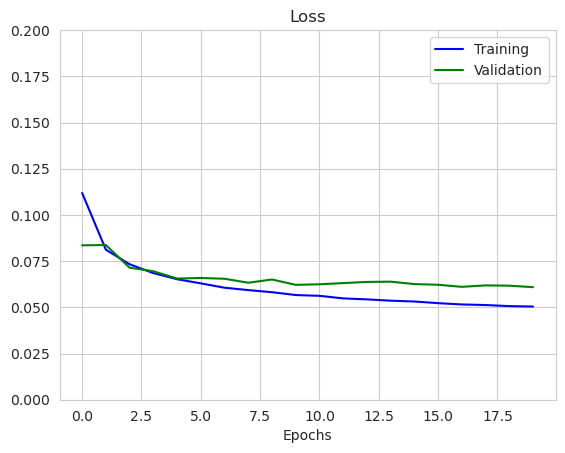

In [13]:
def plot_metrics(metric_name, title, ylim=5):
    sns.set_style("whitegrid")
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.xlabel("Epochs")
    plt.legend(["Training", "Validation"])
    sns.set_style("white")

plot_metrics(metric_name='loss', title="Loss", ylim=0.2)

In [14]:
# Matplotlib config
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0') # Matplotlib fonts

# Utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28 * n])
    plt.imshow(left)
    plt.figure(figsize=(17, 3))
    plt.yticks([])
    plt.xticks([28 * x + 14 for x in range(n)], predictions)

    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # Bad predictions in red

    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28 * n])
    plt.imshow(right)

You can see sample results for 10 pairs of items below.

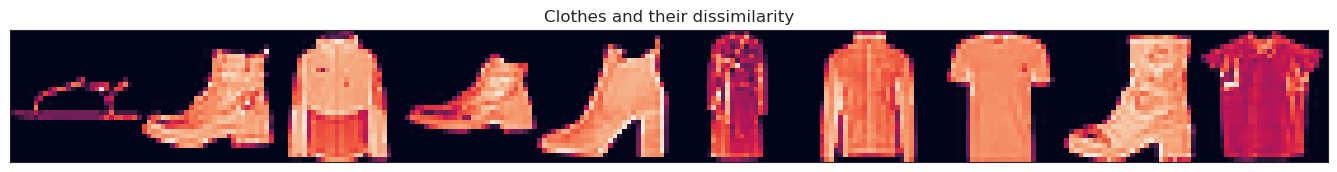

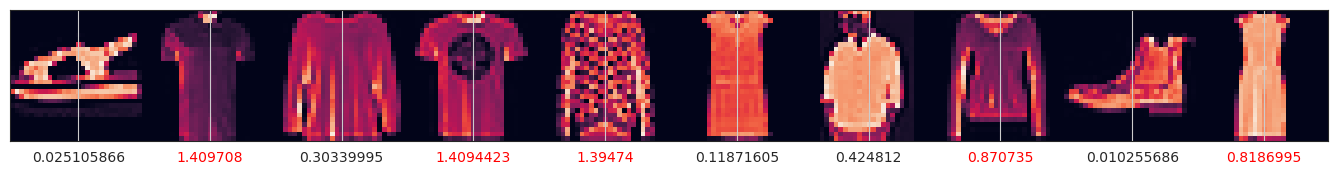

In [15]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_y[indexes], "Clothes and their dissimilarity", 10)

In [16]:
!rm *.png